# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
import re

In [32]:
PATH_TO_DATA = "/home/julien/Documents/Polytechnique/4A/MVA/Deep learning/TP2/nlp_project/data/SST"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def cos_simil(self,x1,x2):
        # returns cosine similarity of 2 vectors
        n1 = np.linalg.norm(x1)
        n2 = np.linalg.norm(x2)
        res = np.dot(x1,x2)/(n1*n2)
        return(res)
    
    def most_similar(self, w, K=5, encoded = False):
        # K most similar words: self.score  -  np.argsort 
        if (not encoded): x = self.word2vec[w]
        else : x = w
        v = np.array([self.cos_simil(x,y) for k,y in self.word2vec.items()])
        #v = np.array(list(map(score2(x),self.word2vec)))
        key = list(self.word2vec.keys())
        arg_v = np.argsort(v)
        res = [key[i] for i in arg_v[-K:]]
        return(res[::-1])

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        x1 = self.word2vec[w1]
        x2 = self.word2vec[w2]
        res = self.cos_simil(x1,x2)
        return res


In [53]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=1000000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))
    

Loaded 200000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288558
germany berlin 0.7420295235998394
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'Dog', 'doggie']
['dogs', 'dog', 'pooches', 'Dogs', 'doggies']
['paris', 'france', 'Paris', 'parisian', 'london']
['germany', 'austria', 'europe', 'german', 'berlin']


In [4]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        if idf is False:
            for sent in sentences:
                try:
                    # mean of word vectors
                    #assert False
                    assert not(sent == '')
                    ls_wds = re.split('\W+',sent)
                    ls_wds = [w for w in ls_wds if w not in ['','.']]
                    l_and_w2v = [w for w in ls_wds if w in self.w2v.word2vec]                    
                    emb = np.average([self.w2v.word2vec[w] for w in l_and_w2v],
                                 weights = [1 for w in l_and_w2v], axis = 0)
                    assert not (np.shape(emb) == (0,))
                    #v = np.array([w2v.word2vec[w] for w in l if w in self.w2v.word2vec])

                    sentemb.append(emb)
                except:
                    sentemb.append([0.0 for i in range(300)])

        else: 
            for sent in sentences:
                try:
                    # idf-weighted mean of word vectors
                    #assert False
                    assert not(sent == '')
                    l = re.split('\W+',sent)
                    l = [w for w in l if w not in ['','.']]
                    l_and_w2v = [w for w in l if w in self.w2v.word2vec]
                    emb = np.average([self.w2v.word2vec[w] for w in l_and_w2v],
                                     weights = [idf[w] for w in l_and_w2v], axis = 0)
                    assert not(np.shape(emb)== (0,)) 
                    #v = np.array([w2v.word2vec[w]*idf.get(w) for w in l if w in self.w2v.word2vec])
                    #assert not (np.shape(v) == (0,))
                    #d = np.sum([idf.get(w) for w in l])
                    #s = np.apply_along_axis(sum,0,v)
                    #sentemb.append(s/d)
                    sentemb.append(emb)
                except:
                    sentemb.append([0.0 for i in range(300)])
        return np.vstack(sentemb)
    

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        v = np.array([self.cos_simil(s2,query[0]) for s2 in keys])
        res = [sentences[i] for i in np.argsort(v)[-K:]]
        print(res[::-1])
        return(res[::-1])
    
    
    def cos_simil(self,x1,x2):
        # returns cosine similarity of 2 real valued vectors
        n1 = np.linalg.norm(x1)
        n2 = np.linalg.norm(x2)
        if n1*n2 == 0 : return(-2.)
        res = np.dot(x1,x2)/(n1*n2)
        return(res)
    

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        x1 = self.encode([s1], idf)
        x2 = self.encode([s2], idf)
        return self.cos_simil(x1[0],x2[0])
    
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        n = float(len(sentences))
        for sent in sentences:
            l = re.split('\W+',sent)
            l = [w for w in l if w not in ['','.']]
            for w in l:
                idf[w] = idf.get(w, 0) + 1.
        for word in idf.keys():
            idf[word] = max(1., np.log10(n / (idf[word])))
        return idf

    

In [5]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
text_file = open(os.path.join(PATH_TO_DATA, 'sentences.txt'), "r")
sentences = text_file.read().split('\n')
text_file.close()

idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 5000 pretrained word vectors
['1 smiling african american boy . ', 'blond boy waterskiing . ', 'a small boy following 4 geese . ', 'boy flings mud at girl ', 'a boy jumps on another boy . ']
0.5444733702595054
['1 smiling african american boy . ', '5 women and 1 man are smiling for the camera . ', '3 males and 1 woman enjoying a sporting event ', 'a man rides a 4 wheeler in the desert . ', 'a man in black is juggling 3 flamed bottles . ']
0.5673846483195514


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [8]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE

nmax = 50000

french = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax)
english = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax)


Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [10]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
FR = set(french.word2vec)
EN = set(english.word2vec)

inter = FR.intersection(EN)

X = np.array([french.word2vec[w] for w in inter])
Y = np.array([english.word2vec[w] for w in inter])

X = X.T
Y = Y.T

In [11]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector
import scipy.linalg
# TYPE CODE HERE
U, sigma, Vh = scipy.linalg.svd(Y.dot(X.T))
W = U.dot(Vh)

In [14]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE

print("French to English")
for w in ['rapide', 'chien', 'ordinateur', 'paris', 'allemagne', 'noir']:
    v = french.word2vec[w]
    print(w, " : ", english.most_similar(W.dot(v), encoded = True))
    
    
print("English to French")
for w in ['eat', 'write', 'dogs', 'paris', 'germany']:
    v = english.word2vec[w]
    print(w, " : ", french.most_similar(np.linalg.inv(W).dot(v), encoded = True))

French to English
rapide  :  ['faster', 'quicker', 'slower', 'slow', 'fast']
chien  :  ['dog', 'poodle', 'terrier', 'dogs', 'spaniel']
ordinateur  :  ['computers', 'computer', 'mainframe', 'workstation', 'programmable']
paris  :  ['paris', 'parisian', 'rouen', 'gallimard', 'sorbonne']
allemagne  :  ['germany', 'rhineland', 'gelsenkirchen', 'saarland', 'bavaria']
noir  :  ['black', 'white', 'noir', 'coloured', 'yellow']
English to French
eat  :  ['mange', 'mangent', 'mangeant', 'manger', 'eat']
write  :  ['écrit', 'écrire', 'write', 'écrivant', 'réécrire']
dogs  :  ['chiens', 'dogs', 'chats', 'dog', 'chien']
paris  :  ['paris', 'parisienne', 'lyon', 'versailles', 'paris,']
germany  :  ['allemagne', 'germany', 'rfa', 'karlsruhe', 'düsseldorf']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [30]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
def load_SST(fname, labels = True):
    X = []
    Y = []
    if labels:
        with io.open(fname, encoding='utf-8') as f:
            for i, l in enumerate(f):
                score, sentence = l.split(' ', 1)
                X.append(sentence)
                Y.append(int(score))
        Y = np.array(Y)
        return X, Y
    else:
        with io.open(fname, encoding='utf-8') as f:
            for i, l in enumerate(f):
                X.append(l)
        return X
    
X_train, Y_train = load_SST('./data/SST/stsa.fine.train')
X_dev, Y_dev = load_SST('./data/SST/stsa.fine.dev')
X_test = load_SST('./data/SST/stsa.fine.test.X', labels = False)


In [33]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)
s2v = BoV(w2v)

X_train_f = s2v.encode(X_train, idf=False)
X_dev_f = s2v.encode(X_dev, idf=False)
X_test_f = s2v.encode(X_test, idf=False)
X_train_t = s2v.encode(X_train, idf=s2v.build_idf(X_train))
X_dev_t = s2v.encode(X_dev, idf=s2v.build_idf(X_dev))
X_test_t = s2v.encode(X_test, idf=s2v.build_idf(X_test))

Loaded 25000 pretrained word vectors


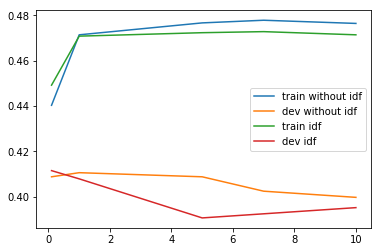

In [34]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE

import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

C_list = [0.1, 1., 5., 7., 10.]
train_f = []
dev_f = []
train_t = []
dev_t = []
for C in C_list:
    model = LogisticRegression(penalty='l2', C=C, 
                               class_weight=None, random_state=None,
                               max_iter=100, multi_class='multinomial', verbose=0,
                               warm_start=False, n_jobs=None, solver = 'newton-cg')
    model.fit(X_train_f, Y_train)
    train_f.append(model.score(X_train_f, Y_train))
    dev_f.append(model.score(X_dev_f, Y_dev))
        
    model = LogisticRegression(penalty='l2', C=C, 
                               class_weight=None, random_state=None,
                               max_iter=100, multi_class='multinomial', verbose=0,
                               warm_start=False, n_jobs=None, solver = 'newton-cg')
    model.fit(X_train_t, Y_train)
    train_t.append(model.score(X_train_t, Y_train))
    dev_t.append(model.score(X_dev_t, Y_dev))

C = C_list[np.argmax(dev_f)]
model = LogisticRegression(penalty='l2', C=C, 
                               class_weight=None, random_state=None,
                               max_iter=100, multi_class='multinomial', verbose=0,
                               warm_start=False, n_jobs=None, solver = 'newton-cg')
model.fit(X_train_f, Y_train)

plt.figure()
plt.plot(C_list, train_f)
plt.plot(C_list, dev_f)
plt.plot(C_list, train_t)
plt.plot(C_list, dev_t)
plt.legend(['train without idf', 'dev without idf', 'train idf', 'dev idf'])
plt.show()

In [35]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE

Y_test = model.predict(X_test_f)

outname = "logreg_bov_y_test_sst.txt"
if os.path.exists(outname): 
    os.remove(outname)
file = open(outname, "w")
for y in Y_test:
    file.write(str(y)+'\n')
file.close() 

! wc -l logreg_bov_y_test_sst.txt

2210 logreg_bov_y_test_sst.txt


In [9]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [37]:
import keras

In [38]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "../../data/"

# TYPE CODE HERE

def load_SST_to_string(fname, labels = True):
    X, Y = [], []
    if labels:
        with io.open(fname, encoding='utf-8') as f:
            for i, l in enumerate(f):
                score, sentence = l.split(' ', 1)
                X.append(sentence)
                Y.append(int(score))
        Y = np.array(Y)
        return X, Y
    else:
        with io.open(fname, encoding='utf-8') as f:
            for i, l in enumerate(f):
                X.append(l)
        return X

X_train, Y_train = load_SST_to_string('./data/SST/stsa.fine.train')
X_dev, Y_dev = load_SST_to_string('./data/SST/stsa.fine.dev')
X_test = load_SST_to_string('./data/SST/stsa.fine.test.X', labels = False)


In [39]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE

from keras.preprocessing.text import one_hot
#     https://keras.io/preprocessing/text/

def one_hot_process(X):
    Xh = []
    for x in X:
        Xh.append(one_hot(x, 5000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' '))
    return Xh

X_train = one_hot_process(X_train)
X_dev = one_hot_process(X_dev)
X_test = one_hot_process(X_test)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
Y_train = enc.fit_transform(Y_train.reshape(-1, 1))
Y_dev = enc.transform(Y_dev.reshape(-1, 1))



/home/julien/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [40]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences
#     https://keras.io/preprocessing/sequence/

X_train = pad_sequences(X_train, maxlen=50, dtype='int32', padding='pre', truncating='pre', value=0.0)
X_dev = pad_sequences(X_dev, maxlen=50, dtype='int32', padding='pre', truncating='pre', value=0.0)
X_test = pad_sequences(X_test, maxlen=50, dtype='int32', padding='pre', truncating='pre', value=0.0)

## 4.2 - Design and train your model

In [41]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

from keras import backend as K
K.set_learning_phase(1)

embed_dim  = 32 # 32  # word embedding dimension
nhid       = 64 # 64 # number of hidden units in the LSTM
vocab_size = 5000 # 1000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.3, recurrent_dropout=0.3)) #0.2 0.2
model.add(Dense(n_classes, activation='sigmoid'))


In [42]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 185,157
Trainable params: 185,157
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64
n_epochs = 6 

history = model.fit(X_train, Y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, Y_dev))


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 6s 645us/step - loss: 1.1622 - acc: 0.4732 - val_loss: 1.5989 - val_acc: 0.3606
Epoch 2/6
8544/8544 [==============================] - 13s 1ms/step - loss: 1.0883 - acc: 0.5137 - val_loss: 1.6220 - val_acc: 0.3388
Epoch 3/6
8544/8544 [==============================] - 12s 1ms/step - loss: 1.0129 - acc: 0.5625 - val_loss: 1.7662 - val_acc: 0.3415
Epoch 4/6
8544/8544 [==============================] - 12s 1ms/step - loss: 0.9383 - acc: 0.6052 - val_loss: 1.8530 - val_acc: 0.3224
Epoch 5/6
8544/8544 [==============================] - 12s 1ms/step - loss: 0.8581 - acc: 0.6479 - val_loss: 1.9723 - val_acc: 0.3297
Epoch 6/6
8544/8544 [==============================] - 13s 1ms/step - loss: 0.7936 - acc: 0.6834 - val_loss: 2.0297 - val_acc: 0.3524


In [45]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
Y_test = model.predict(X_test)
Y_test = np.argmax(Y_test, axis = 1)

outname = "logreg_lstm_y_test_sst.txt"
if os.path.exists(outname): 
    os.remove(outname)
file = open(outname, "w")
for y in Y_test:
    file.write(str(y)+'\n')
file.close() 

! wc -l logreg_lstm_y_test_sst.txt

2210 logreg_lstm_y_test_sst.txt


## 4.3 -- innovate !

In [ ]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
